## Install packages

In [1]:
!pip install fairlearn
!pip install scikit-learn

## Import Packages

In [2]:
import pandas as pd
#sklearn packages
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

#fairlearn metrics
from fairlearn.metrics import (
    MetricFrame,
    false_positive_rate,
    true_positive_rate,
    selection_rate,
    count,
)

#fairlearn mitigation algorithm
from fairlearn.reductions import (ExponentiatedGradient, 
                                  DemographicParity, 
                                  TruePositiveRateParity, 
                                  EqualizedOdds, 
                                  ErrorRateParity)


## Get Sample Dataset from sklearn

In [5]:
data = fetch_openml(data_id=1590, as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == ">50K") * 1

## Dataset Description

* We are using [UCI adult dataset](https://archive.ics.uci.edu/ml/datasets/Adult)
* objective is to predict whether a person makes more **(label 1)** or **less (0)** than **$50,000 a year**.


In [6]:
data.data.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States


## Defining Sensitive Feature
Which groups are most likely to be disproportionately negatively affected? 
We see that male and female groups can be differnetly affected hence we define **sex** as sensitive feature.

In [8]:
sex = data.data["sex"]

## Training a Model
We train a decision tree classifer to predict the target variable.

In [11]:
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)
y_pred = classifier.predict(X)

## Fareness Assement with Metric Frame

* Fairlearn provides fairness-related metrics that can be compared between groups and for the overall population.
* We can use existing metrics from sklearn

In [12]:
#defining a metric frame object
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values

metrics = {
    "false positive rate": false_positive_rate,
    "true positive rate": true_positive_rate,
    "selection rate": selection_rate,
    "accuracy": accuracy_score,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)

In [13]:
## overall performace metrics of model
metric_frame.overall

false positive rate    0.052725
true positive rate     0.517156
selection rate         0.163855
accuracy               0.844355
dtype: object

In [14]:
# The disaggregated metrics are stored in a pandas Series metric_frame.by_group:
metric_frame.by_group

,false positive rate,true positive rate,selection rate,accuracy
sex,,,,
Female,0.016363,0.448276,0.06355,0.925148
Male,0.075796,0.529441,0.213599,0.804288


array([[<AxesSubplot:title={'center':'false positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

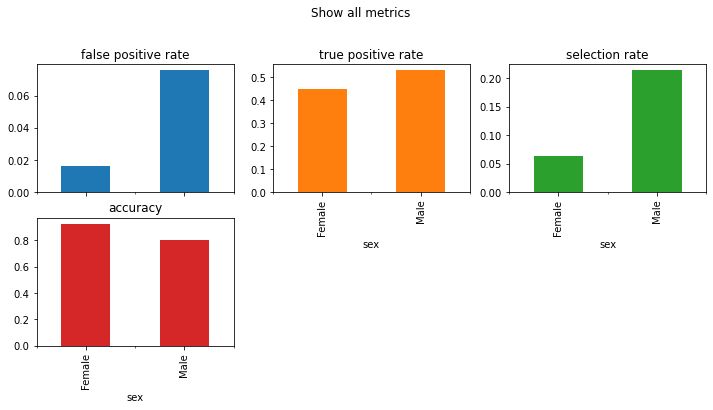

In [15]:
#Fairlearn also allows us to quickly plot these metrics from the fairlearn.metrics.MetricFrame
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

### From the above it is clearly visible how our model is Biased
* We see that Male have a higher selection rate as compared to females.
* Also We see that model predictions are better for female population as compared to male population as is makes more mistake while predicting for male population.
* Also we see that false positive rate is much higher for Male population as compared to female.

# Mitigating Unfairness

We apply exponentialgradient as a wrapper on our Decision Tree classifier.

Various fairness constraint has been applied and we look at performance measure after applying each constraints.

* **Demographic Parity**

In [30]:
#### cost optimization based on demographic parity constraint
### demographic parity constraints - overall selection rate(rate of predicting 1) = selection rate withing each group(defined by sensitive feature)
constraint = DemographicParity(difference_bound=0.01)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)
metric_frame_mitigated = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)

print(metric_frame_mitigated.overall)
print(metric_frame_mitigated.by_group)

false positive rate     0.06882
true positive rate     0.473175
selection rate         0.165575
accuracy               0.821588
dtype: object
       false positive rate true positive rate selection rate  accuracy
sex                                                                   
Female            0.086598           0.715093       0.155262  0.891737
Male               0.05754           0.430026       0.170689  0.786799


array([[<AxesSubplot:title={'center':'false positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

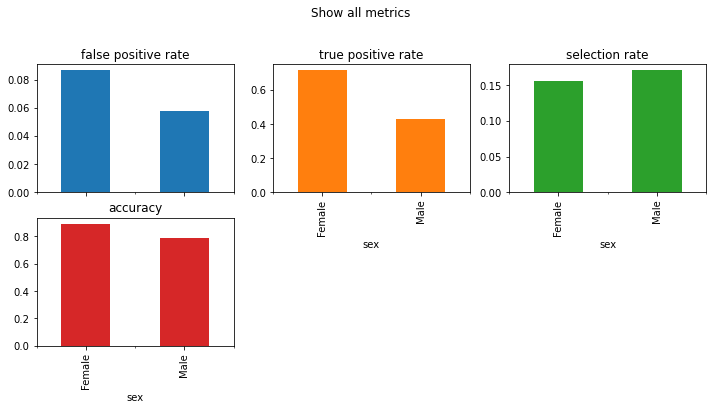

In [31]:
metric_frame_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

* **True Positive rate parity**

In [32]:
#### cost optimization based on true positive rate parity constraint
### true positive rate parity constraints - TPR overall = TPR withing each group(defined by sensitive feature)
constraint = TruePositiveRateParity(difference_bound=0.01)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)
metric_frame_mitigated = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)

print(metric_frame_mitigated.overall)
print(metric_frame_mitigated.by_group)

false positive rate    0.062603
true positive rate     0.533927
selection rate         0.175382
accuracy               0.840854
dtype: object
       false positive rate true positive rate selection rate  accuracy
sex                                                                   
Female            0.035915           0.521198       0.088933  0.915699
Male              0.079535           0.536197       0.218254  0.803737


* **equalized odds parity**

In [17]:
#### cost optimization based on equalized odds parity constraint
### equalized odds parity constraints - takes into account both TPR and FPR
constraint = EqualizedOdds(difference_bound=0.01)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)
metric_frame_mitigated = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)

print(metric_frame_mitigated.overall)
print(metric_frame_mitigated.by_group)

false positive rate    0.074203
true positive rate     0.562334
selection rate         0.191004
accuracy               0.838827
dtype: object
       false positive rate true positive rate selection rate  accuracy
sex                                                                   
Female            0.063926           0.567552       0.118948  0.895813
Male              0.080723           0.561404       0.226738  0.810567


array([[<AxesSubplot:title={'center':'false positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

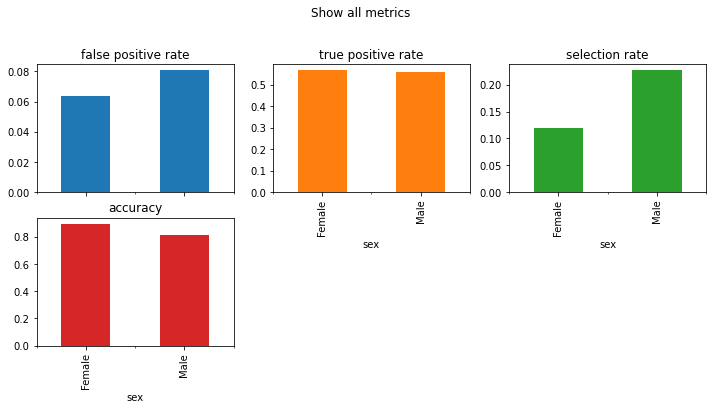

In [18]:
metric_frame_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

* **Error rate parity**

In [19]:
#### cost optimization based on error rate parity constraint
### error rate parity constraints - error rate/accuracy overall = error rate/accuracy withing each group(defined by sensitive feature)
constraint = ErrorRateParity(difference_bound=0.01)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)
metric_frame_mitigated = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)

print(metric_frame_mitigated.overall)
print(metric_frame_mitigated.by_group)

false positive rate    0.078886
true positive rate     0.455806
selection rate         0.169076
accuracy               0.809774
dtype: object
       false positive rate true positive rate selection rate  accuracy
sex                                                                   
Female             0.08535           0.050311       0.081522   0.82022
Male              0.074784           0.528131       0.212496  0.804594


array([[<AxesSubplot:title={'center':'false positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>],
       [<AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>]], dtype=object)

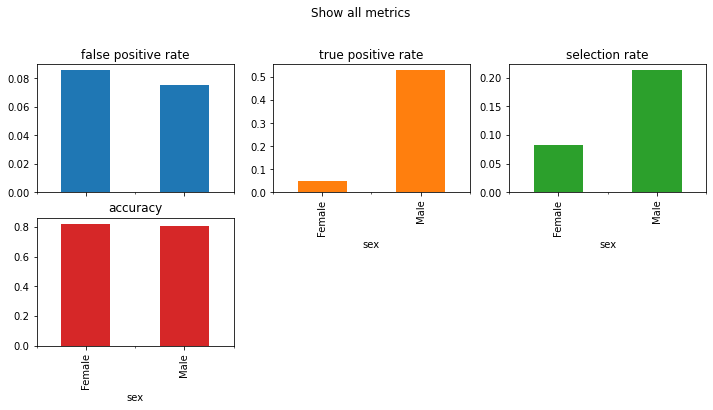

In [20]:
metric_frame_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)